# Load data
- 88 shuffles 

In [ ]:
import configparser
import matplotlib.pyplot as plt

from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker

import numpy as np
import os
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import subprocess

In [ ]:
CL = "HepG2"
GENOME_BUILD = "hg38"

In [ ]:
BASE_PATH= "/dors/capra_lab/users/fongsl/enh_ages/landscape/"

configfile_name = os.path.join(BASE_PATH, "config_landscape.ini")
config = configparser.ConfigParser(allow_no_value=True)
config.read(configfile_name)

## get plotting colors, other parameters

sys.path.append(BASE_PATH)
import config_plot as cp

In [11]:
cCRE = config[f"ENCODE_{CL}_FEATURES"]["DATA_FILE"]

#cCRE_TFBS_ONLY = f"{cCREPATH}enh_tfbs_only.txt"

SHUFF = config[f"ENCODE_{CL}_FEATURES"]["SHUFFLE_FILE"]


RE = config[f"ENCODE_{CL}_FEATURES"]["RESULTS"]
stat_f = config[f"ENCODE_{CL}_FEATURES"]["STAT_FILE"]

## colors

In [75]:
#%%
yg = '#f7fcb9'
stemg = '#addd8e'
kellyg = '#31a354'

y = mcolors.to_rgba(yg)
lg = mcolors.to_rgba(stemg)
g = mcolors.to_rgba(kellyg)


colors = [g, lg, y]  # kelly -> light - > yellow
cmap_name = 'yg_'
CM = LinearSegmentedColormap.from_list(cmap_name, colors, N=3)

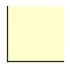

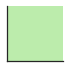

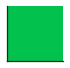

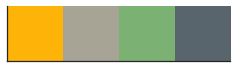

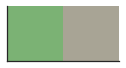

In [76]:
#%%
colors = [ "ecru"]
y_ = sns.xkcd_palette(colors)
sns.palplot(y_)

colors = [ "light sage"]
stemg = sns.xkcd_palette(colors)
sns.palplot(stemg)

colors = [ "shamrock green"]
kellyg = sns.xkcd_palette(colors)
sns.palplot(kellyg)

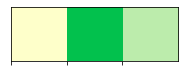

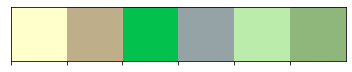

In [14]:
colors = ["ecru","shamrock green", "light sage"]
yg = sns.xkcd_palette(colors)
sns.palplot(yg)

colors = ["ecru",  "putty","shamrock green", "cool grey","light sage", "lichen"]
yg_shuf = sns.xkcd_palette(colors)
sns.palplot(yg_shuf)

# Functions

- add architecture label
- reclassify complex primate enhancers as simple if they do not have a human specific sequence
- format tthe dataframe, call reclassify primate enhancer function, add taxon information
- calculate mann whitney u between columns
- plot stratified MRCA
- get frequency of architecture v. shuffle
- plot arch enh v. shuffle frequency
- plot arch v. shuffle fold-change

In [77]:
def add_arch_labels(df):

    df["arch"] = "complex_core"

    df.loc[df.core_remodeling ==0, "arch"] = "simple"
    df.loc[df.core ==0, "arch"] = "complex_derived"

    return df


def reEval_PrimComplex(enh):

    # get all the complex enhancers w/ primate core ages
    prComEnhID = enh.loc[(enh.core ==1) &
    (enh.core_remodeling ==1) &
    (enh.taxon2.str.contains("Primate"))]["enh_id"].unique()

    # get all the complex enhancer ids where there is a real human derived sequence
    pr_complex = enh.loc[(enh.enh_id.isin(prComEnhID)) &
    (enh.core_remodeling == 1) &
    (enh.core ==0) &
    (enh.mrca ==0),
    ]["enh_id"]


    # i'm going to reassign any primate complex enhancer
    # where derived regions are from other primates
    # get the set of primate complex enhancers w/ primate derived sequences
    # and rename them as simple enhancers
    pr_simple = set(prComEnhID) - set(pr_complex)

    # reassign core and core remodeling columns
    enh.loc[enh.enh_id.isin(pr_simple), "core"] = 1
    enh.loc[enh.enh_id.isin(pr_simple), "core_remodeling"] = 0
    return enh


def format_syndf(enh_age_file):

    syn_cols = ["chr_syn", "start_syn", "end_syn",
    "enh_id",
    "chr", "start", "end",
    "seg_index", "core_remodeling", "core",
    "mrca",]

    syn = pd.read_csv(enh_age_file, sep ='\t', header = None, names = syn_cols)

    syn["syn_id"] = syn.chr_syn + ":" + syn.start_syn.map(str) + "-" + syn.end_syn.map(str)

    syn["syn_len"] = syn.end_syn - syn.start_syn
    syn["enh_len"] = syn.end - syn.start


    # age and taxon file
    syn_gen_bkgd_file = f"/dors/capra_lab/projects/enhancer_ages/{GENOME_BUILD}_syn_gen_bkgd.tsv"
    syn_gen_bkgd= pd.read_csv(syn_gen_bkgd_file, sep = '\t') # read the file
    syn_gen_bkgd[["mrca", "mrca_2"]] = syn_gen_bkgd[["mrca", "mrca_2"]].round(3) # round the ages

    syn_gen_bkgd = syn_gen_bkgd[["mrca", "taxon", "mrca_2", "taxon2"]] # whittle down the df
    syn["mrca"] = syn["mrca"].round(3) # round the ages

    syn = pd.merge(syn, syn_gen_bkgd, how = "left", on = "mrca")
    syn = reEval_PrimComplex(syn)
    syn[syn_cols].to_csv(enh_age_file, sep = "\t", header = False, index = False)
    labeled_syn = add_arch_labels(syn) # add architecture labels

    return labeled_syn

In [78]:
def get_mwu(dataset_col, id_col, test_dif, df, statf):

    results_dict = {}

    for dataset in df[dataset_col].unique(): # simple complex core derived
        print(dataset)
        val_list = [] # two lists for mwu
        median_list = [] # median of list,
        mean_list = [] # mean of list

        id_col_list = df[id_col].unique() # get the variables to compare lists
        comp_name = f"{dataset_col}_{id_col_list[0]}_v_{id_col_list[1]}" # for annotation


        test = df.loc[df[dataset_col] == dataset] # filter dataset on variable

        for comp in id_col_list:
            print(comp)
            values = list(test.loc[(test[id_col] == comp), test_dif])
            val_list.append(values)
            median_list.append(np.median(values))
            mean_list.append(np.mean(values))

        print("val list len", len(val_list))
        stat_, p_ = stats.mannwhitneyu(val_list[0], val_list[1])

        mwu_df = pd.DataFrame({
        "comparison": [comp_name],
        "dataset": [dataset],
        "stat": [stat_],
        "P": [p_],
        f"median{id_col_list[0]}": [median_list[0]],
        f"median{id_col_list[1]}": [median_list[1]],
        f"mean{id_col_list[0]}": [mean_list[0]],
        f"mean{id_col_list[1]}": [mean_list[1]],
        })
        results_dict[dataset] = mwu_df

    results = pd.concat(results_dict.values()) # concat results
    
    with open(stat_f, "a") as writer:
        for i, row in results.iterrows():
            info = row.to_string()
            print(info)
            writer.write(info)

    return results

In [79]:
def plot_mrca_stratified(x, y, data, hue, palette, outf):

    order_dict = {
    "arch" : ["simple", "complex_core", "complex_derived"],
    "mrca_2": list(data.mrca_2.sort_values().unique())
    #"mrca_2" : [0.0, 0.126, 0.131,  0.152, 0.175, 0.308, 0.38, 0.49, 0.656, 0.957]
    }

    hue_order_dict = {
    "arch__": ["simple-cCRE", 'simple-SHUFFLE', 'complex-cCRE', 'complex-SHUFFLE'],
    "id":["cCRE", "SHUFFLE"],
    "id2": ["simple-cCRE", "simple-SHUFFLE", "complex_core-cCRE",
    "complex_core-SHUFFLE", "complex_derived-cCRE", "complex_derived-SHUFFLE"]
    }

    ylab_dict = {
    "syn_len": "syntenic length",
    "pct_enh": "percent\nenhancer sequence"
    }

    xlab_dict = {
    "mrca_2": ["homo", "prim", "euar", "bore", "euth", "ther", "mam", "amni", "tetr", "sarg", "vert"],
    "arch": ["simple", "complex\ncore", "complex\nderived"]
    }

    figsize_dict = {
    "mrca_2": (12,6),
    "arch":(6,6)
    }


    xlabs = xlab_dict[x]
    ylab =  ylab_dict[y]
    order = order_dict[x]
    hue_order = hue_order_dict[hue]
    figsize = figsize_dict[x]
    custom_params = {"axes.spines.right": False, "axes.spines.top": False, "font.size":16}
    sns.set_theme(style="white", font="Roboto", rc=custom_params, font_scale = 1.2)

    fig, ax = plt.subplots(figsize = figsize)
    sns.barplot(x=x, y=y, data = data,
                hue = hue,
                palette = palette,
                order = order,
                hue_order = hue_order, estimator = np.median,
                )

    ax.set(ylabel = ylab, xlabel = "")
    ax.set_xticklabels(xlabs, rotation = 90)
    ax.legend(bbox_to_anchor = (1,1))
    ax.invert_xaxis()
    plt.savefig(outf, bbox_inches = 'tight')

In [80]:
def MRCA_frequency(catdf, cols, var, stat_f):

    age_dict = {} # collect age frequency results per dataset
    summary_age_dict = {} # collect summarized age frequencies per dataset

    for n, dataset in enumerate(catdf["id"].unique()):
        # count n enhancers in architecture per age
        test = catdf.loc[catdf["id"] == dataset]

        age = test.groupby(cols)["enh_id"].count().reset_index()

        # rename columns
        age.columns = cols + ["counts"]

        # sum total n enhancers in architecture
        cols_no_var = list(set(cols) - set([var]))
        totals = age.groupby(cols_no_var)["counts"].sum().reset_index()
        # rename columns
        totals.columns = cols_no_var + ["total_id"]

        # merge dataframes
        age = pd.merge(age, totals, how = "left")

        # calculate the % of architecture in each age
        age["freq"] = age.counts.divide(age.total_id)

        age["dataset_name"] = dataset
        age_dict[n] = age

        # summarize frequencies across architectures, before/after eutherian.
        eutherian = age.loc[age["mrca_2"] == 0.19][[ "id", "freq"]]
        eutherian["category"] = "eutherian"

        younger_thaneuth = age.loc[age["mrca_2"] <0.19].groupby(["id"])["freq"].sum().reset_index()
        younger_thaneuth["category"] = "younger than eutherian"

        older_thaneuth = age.loc[age["mrca_2"] >0.19].groupby(["id"])["freq"].sum().reset_index()
        older_thaneuth["category"] = "older than eutherian"

        summarized_freq = pd.concat([eutherian, younger_thaneuth, older_thaneuth])
        summarized_freq["dataset_name"] = dataset

        summary_age_dict[n] = summarized_freq

    # concat age and summarized frequency dataframes
    ages = pd.concat(age_dict.values())
    summarized_freq = pd.concat(summary_age_dict.values())

    # calculate fold-change of enh v. shuf expectation per shuffle


    # select only the enhancer and specific shuffle instance
    enhdf = ages.loc[ages["id"] == "cCRE"]

    shuf_ = ages.loc[ages["id"] != "cCRE"]

    merge_cols = list(set(cols) - set(["id"]))

    fc = pd.merge(shuf_, enhdf, how = "left", on =merge_cols)

    # calculate fold changes
    fc["fold_change"] = fc["freq_y"].divide(fc["freq_x"])
    
    col_id = "_".join(cols)
    with open(stat_f, "a") as writer:
        writer.write("\n\nages\n\n")
        for i, row in ages.iterrows():
            print(row)
            writer.write(row.to_string())

        writer.write("\n\nfold change\n\n")
        for i, row in fc.iterrows():
            writer.write(row.to_string())

        writer.write("\n\n summarized frequencies\n\n")
        for i, row in summarized_freq.iterrows():
            writer.write(row.to_string())

    return ages, fc

In [81]:
def plot_arch_freq(age_arch_freq, age_freq):
    plots = {"age_arch" : age_arch_freq, "age": age_freq}

    for name, frame in plots.items():

        if name == "age_arch": # arrange order and colors of plot.
            frame["plot_hue"] = frame["arch"].astype(str) + "-" + frame["id"].astype(str)
            order = ["simple-cCRE", "simple-SHUFFLE",
            "complex_core-cCRE", "complex_core-SHUFFLE",
            "complex_derived-cCRE", "complex_derived-SHUFFLE"]
            hue = "plot_hue"
            p = yg

        else:
            order = ["cCRE", "SHUFFLE"]
            hue = "id"
            p = EPAL


        if GENOME_BUILD == "hg38":
            xlabs = ["Prim", "Euar", "Bore", "Euth", "Ther", "Mam", "Amni", "Tetr", "Sarg", "Vert"] # set xlabels
        else:
            xlabs = ["Homo", "Prim", "Euar", "Bore", "Euth", "Ther", "Mam", "Amni", "Tetr", "Vert"]

        custom_params = {"axes.spines.right": False, "axes.spines.top": False, "font.size":16}
        sns.set_theme(style="white", font="Roboto", rc=custom_params, font_scale = 1.2)
        fig, ax = plt.subplots(figsize = (6,6))
        x, y = "mrca_2", "freq"
        data = frame

        sns.barplot(x = x, y=y,
        data = data,
        hue = hue,
        hue_order = order,
        palette = p)

        ax.set_xticklabels(xlabs, rotation = 90)
        ax.legend(bbox_to_anchor = (1,1))

        outf = f"{RE}{name}_freq_per_age.pdf"

        plt.savefig(outf, bbox_inches= "tight")

In [85]:
def plot_arch_fc(age_arch_fc, age_fc, build, arch):
    print(build, arch)
    
    plots = {"age_arch":age_arch_fc, "age_tfbs": age_fc}
    color_dict ={"simple": y_, "complex_core": kellyg, "complex_derived": stemg}
    archs = ["simple", "complex_core", "complex_derived"]

    # don't plot the entire dataset if you just want to plot FC of one architecture.
    if arch in archs:
        plots.pop("age_tfbs")
        print(plots.keys())

    for name, fc in plots.items():

        fc['log2'] = np.log2(fc["fold_change"])


        if name == "age_arch" and arch in archs:
            order = [arch] # set order
            hue = "arch" # set hue
            data = fc.loc[fc.arch == arch] # filter dataset
            p = color_dict[arch] # get the color corresponding to architecture.

        elif name == "age_arch" and arch == "all":
            order = ["simple", "complex_core", "complex_derived"]
            hue = "arch"
            data = fc
            p = yg

        elif name =="age_tfbs":
            arch = None
            order = ["cCRE"]
            hue = "id_y"
            data = fc
            p = EPAL

        backbone_df = age_arch_fc["mrca_2"].copy().drop_duplicates().reset_index()
        data = pd.merge(backbone_df, data, how = "left").fillna(0).sort_values(by = "mrca_2")
        data["counts_y"] = data["counts_y"].astype(int)

        if build == "hg38":
            xlabs = ["Homo","Prim", "Euar", "Bore", "Euth", "Ther", "Mam", "Amni", "Tetr", "Sarg", "Vert"]

        else:
            xlabs = ["Homo", "Prim", "Euar", "Bore", "Euth", "Ther", "Mam", "Amni", "Tetr", "Vert"]

        custom_params = {"axes.spines.right": False, "axes.spines.top": False, "font.size":16}
        sns.set_theme(style="white", font="Roboto", rc=custom_params, font_scale = 1.2)

        fig, ax = plt.subplots(figsize = (6,6))
        x, y = "mrca_2", "log2"


        splot = sns.barplot(x = x, y=y,
        data = data,
        hue = hue,
        hue_order = order,
        palette = p)


        for n, p in enumerate(splot.patches):
            value = data.iloc[n]["counts_y"]
            splot.annotate(value,
                           (p.get_x() + p.get_width() / 2.,0.05),
                           ha = 'center', va = 'baseline',
                           size=15,
                           rotation = 90,
                           color = "k",
                           xytext = (0, 1),
                           textcoords = 'offset points'
                           )

        ax.set(ylabel = "Fold-Change v. Bkgd\n(log2-scaled)", xlabel = "")
        ax.set_xticklabels(xlabs, rotation = 90)
        ax.legend(bbox_to_anchor = (1,1))
        
        ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(2**x))
        ax.yaxis.set_major_formatter(ticks)
        ax.yaxis.set_major_locator(MultipleLocator(1))
        ax.invert_xaxis()
        outf = os.path.join(RE, f"Fig2B_{name}_{arch}_fold_change_per_age.pdf")


    plt.savefig(outf, bbox_inches= "tight")

# get dataframes

merge enh and shuffled

In [38]:
out_df = os.path.join(RE, f"cCRE_{CL}_shuf_df.txt")

if os.path.exists(out_df) is False:
    enh = format_syndf(cCRE)
    enh["id"] = "cCRE"

    shuf = format_syndf(SHUFF)
    shuf["id"] = "SHUFFLE"


    df = pd.concat([enh, shuf])

    df.drop_duplicates()

    df.to_csv(out_df, sep ='\t', index = False)
else:
    df = pd.read_csv(out_df, sep = "\t")

combine enhancer and shuffled dataframes 

# summarize architecture lengths per enhancer

In [41]:
out_f = os.path.join(RE, f"sum_{CL}_arch_len.txt")

if os.path.exists(out_f) is False:

    sum_archlen = df.groupby(['id', 'enh_id', 'enh_len', 'core_remodeling', 'core'])["syn_len"].sum().reset_index().drop_duplicates()

    sum_archlen = add_arch_labels(sum_archlen) # add architecture labels

     # calculate percent arch per enhancer
    sum_archlen["pct_enh"] = sum_archlen.syn_len.divide(sum_archlen.enh_len)


    # add oldest ages of enhancer information
    enh_mrcas = df.groupby("enh_id")[["mrca_2", "taxon2"]].max().reset_index()
    sum_archlen = pd.merge(sum_archlen, enh_mrcas, how = "left", on = "enh_id")


    shuf_remove_ids = sum_archlen.loc[(sum_archlen["mrca_2"] == 0) & (sum_archlen.core ==0), "enh_id"]
    sum_archlen = sum_archlen[~sum_archlen["enh_id"].isin(shuf_remove_ids)]

    ## summarize simple v. complex architectures only

    sum_archlen["arch_"] = "simple"
    sum_archlen.loc[sum_archlen.core_remodeling ==1, "arch_"] = "complex"
    sum_archlen["arch__"] = sum_archlen["arch_"] + "-" + sum_archlen['id']

    # add column for plotting purposes
    sum_archlen["id2"] = sum_archlen["arch"] + "-" + sum_archlen["id"]

    sum_archlen.to_csv(out_f, sep = '\t', index = False)
else:
    sum_archlen = pd.read_csv(out_f, sep = '\t')

# Plots

## age, arch x syn length

In [40]:
out_f

'/dors/capra_lab/projects/enhancer_ages/landscape/results/cCRE/HepG2/sum_HepG2_arch_len.txt'

In [42]:
sum_archlen.head()

,id,enh_id,enh_len,core_remodeling,core,syn_len,arch,pct_enh,mrca_2,taxon2,arch_,arch__,id2
0,SHUFFLE,chr10:10000003-10000202,199,0,1,199,simple,1.000000,0.190,Eutheria,simple,simple-SHUFFLE,simple-SHUFFLE
1,SHUFFLE,chr10:10000871-10001214,343,0,1,343,simple,1.000000,0.190,Eutheria,simple,simple-SHUFFLE,simple-SHUFFLE
2,SHUFFLE,chr10:10001007-10001255,248,0,1,248,simple,1.000000,0.190,Eutheria,simple,simple-SHUFFLE,simple-SHUFFLE
3,SHUFFLE,chr10:100010999-100011174,175,0,1,175,simple,1.000000,0.167,Boreoeutheria,simple,simple-SHUFFLE,simple-SHUFFLE
4,SHUFFLE,chr10:100014949-100015122,173,1,0,132,complex_derived,0.763006,0.190,Primate,complex,complex-SHUFFLE,complex_derived-SHUFFLE


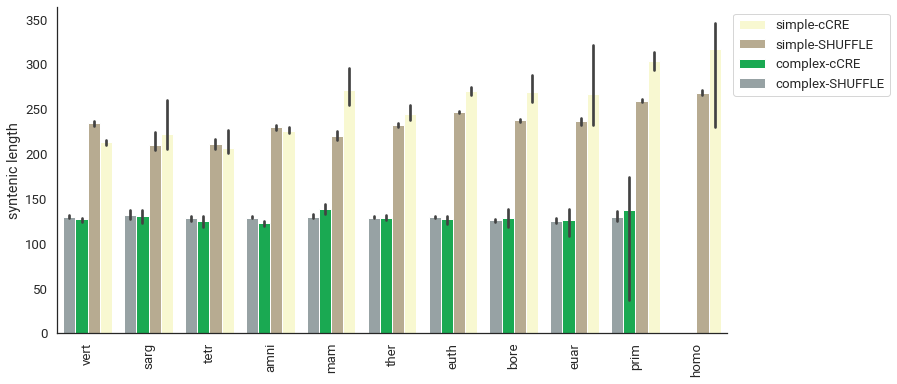

In [47]:
x = "mrca_2"
y = "syn_len"
data = sum_archlen#.sample(frac = 0.05)
hue = "arch__"
palette = yg_shuf
outf = f"{RE}ALL_mrca_x_syn_lengths_arch.pdf"

plot_mrca_stratified(x, y, data, hue, palette, outf)

## FigS-EnhvShuf-synLen
### arch,  syn length

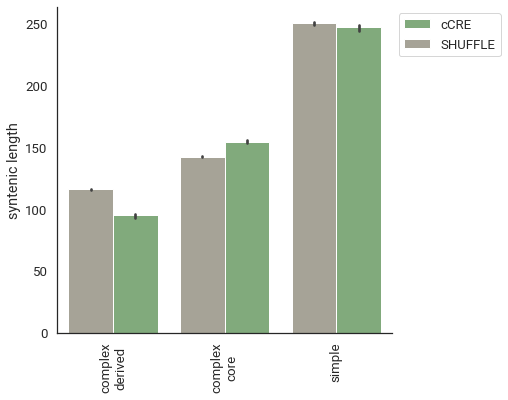

In [48]:
x = "arch"
y = "syn_len"
hue = "id"
palette = EPAL

outf = f"{RE}FigS-EnhvShuf-synLen_cCRE_shuffle.pdf"

plot_mrca_stratified(x, y, data, hue, palette, outf)

### arch,  pct enhancer

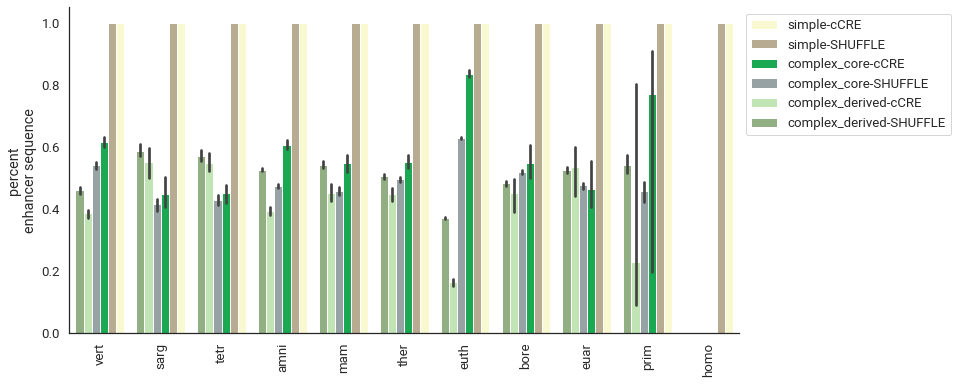

In [49]:
x = "mrca_2"
y = "pct_enh"
hue = "id2"
palette = yg_shuf
outf = f"{RE}ALL_cCRE_percent_arch_mrca_2.pdf"
plot_mrca_stratified(x, y, data, hue, palette, outf)

## FigS CorDer_v_ShufLen
### stratify syn length by age

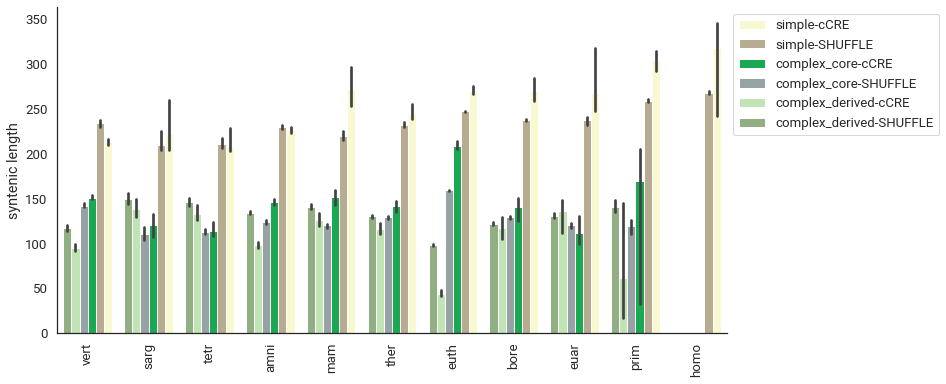

In [50]:
x = "mrca_2"
y = "syn_len"
hue = "id2"
palette = yg_shuf
outf = f"{RE}FigS_CorDer_v_ShufLen_mrca2.pdf"
plot_mrca_stratified(x, y, data, hue, palette, outf)

##  percent architecture

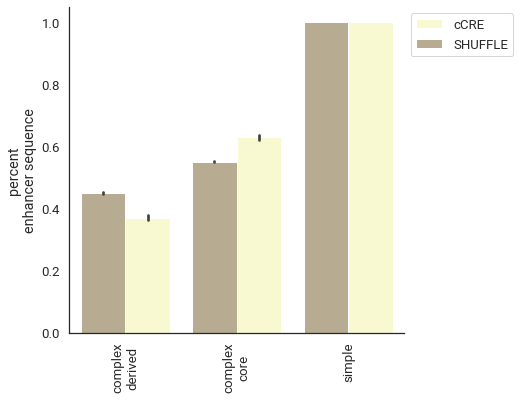

In [51]:
x = "arch"
y = "pct_enh"
hue = "id"
outf = f"{RE}ALL_cCRE_percent_all.pdf"
sns.set(font="Roboto")
plot_mrca_stratified(x, y, data, hue, palette, outf)

# Figure 1, 2A - pie charts

In [52]:
pie_ = data.loc[data.id == "cCRE"][["arch_", "enh_id"]].drop_duplicates().groupby(["arch_"])["enh_id"].count().reset_index()


with open(stat_f, "a") as writer:
    writer.write("\n\n # percent of simple and complex #\n\n")
    for i, row in pie_.iterrows():
        writer.write(row.to_string())
pie_

,arch_,enh_id
0,complex,27548
1,simple,26316


In [53]:
list(data)

['id',
 'enh_id',
 'enh_len',
 'core_remodeling',
 'core',
 'syn_len',
 'arch',
 'pct_enh',
 'mrca_2',
 'taxon2',
 'arch_',
 'arch__',
 'id2']

In [54]:
pie_ = data.loc[data.id == "cCRE"][["arch__", "enh_id"]].drop_duplicates().groupby(["arch__"])["enh_id"].count().reset_index()
pie_

,arch__,enh_id
0,complex-cCRE,27548
1,simple-cCRE,26316


In [55]:
piedf = data.loc[(data.id == "cCRE") & (data.core_remodeling ==1)][["arch", "pct_enh"]].groupby(["arch"])["pct_enh"].median().reset_index()
with open(stat_f, "a") as writer:
    writer.write("\n\n # % core, derived per complex enh#\n\n")
    for i, row in piedf.iterrows():
        writer.write(row.to_string())

In [56]:
pie_

,arch__,enh_id
0,complex-cCRE,27548
1,simple-cCRE,26316


([<matplotlib.patches.Wedge at 0x7f3e08b9b4a8>,
 [Text(-1.1921025419441607, -0.5185475190281704, 'complex_core'),
  Text(1.0087021508758283, 0.43877097763922096, 'complex_derived')],
 [Text(-0.7336015642733296, -0.3191061655557971, '63%'),
  Text(0.5502011732049972, 0.23932962416684778, '37%')])

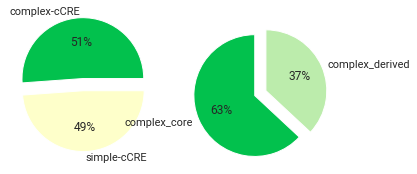

In [57]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set(style = "white", font="Roboto", rc=custom_params)
fig, (ax1, ax2) = plt.subplots(ncols = 2)


y = np.array(pie_.enh_id)
mylabels = list(pie_.arch__)
colors = [ "shamrock green", "ecru"]
amber = sns.xkcd_palette(colors)
myexplode = [0.2, 0]
ax1.pie(y, labels = mylabels, colors = amber, explode = myexplode, autopct='%1.0f%%')
outf = f"{RE}Fig1_Fig2A_pie_chart_arch.pdf"
plt.savefig(outf, bbox_inches = "tight")


y = np.array(piedf.pct_enh)
mylabels = list(piedf.arch)
colors = [ "shamrock green", "light sage"]
amber = sns.xkcd_palette(colors)
myexplode = [0.2, 0]
ax2.pie(y, labels = mylabels, colors = amber, explode = myexplode, autopct='%1.0f%%', startangle = 90)


# Figure 2A 
## stacked barplot: syn lengths

### stratify syn lengths by age -- means

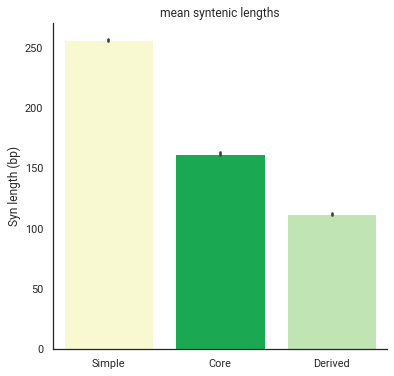

In [58]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="white", font="Roboto", rc=custom_params)
order = ['simple', 'complex_core', 'complex_derived']
labels = ['Simple', 'Core', 'Derived']


fig, ax = plt.subplots(figsize = (6,6))

sns.barplot(x = "arch", y = "syn_len", 
            data =  data.loc[(data.id == "cCRE")], 
            estimator = np.mean,
            palette = yg,
            order = order)
ax.set_xticklabels(labels)

ax.set(ylabel = 'Syn length (bp)', title = 'mean syntenic lengths', xlabel = "")
#ax.legend()


outf = f"{RE}bar_arch_syn_len-mean.pdf"
plt.savefig(outf, bbox_inches = "tight")

### stratify syn lengths by age -- medians

In [59]:
d = data.loc[data.id == "cCRE"][["enh_id","arch", "syn_len"]].drop_duplicates()
s = d.loc[d["arch"] == "simple", "syn_len"]
c = d.loc[d["arch"] == "complex_core", "syn_len"]
dr = d.loc[d["arch"] == "complex_derived", "syn_len"]

s, p = stats.mannwhitneyu(c, dr) 
with open(stat_f, "a") as writer:
    writer.write(f"\n\nMWU core v. der syn length: mwu={s}, p = {p}")

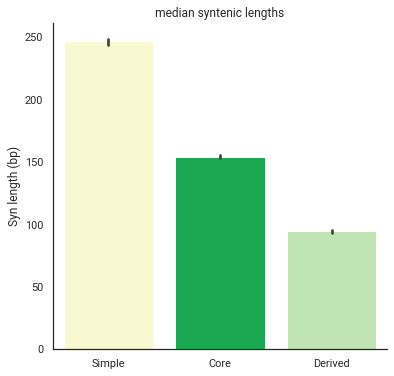

In [60]:
order = ['simple', 'complex_core', 'complex_derived']
labels = ['Simple', 'Core', 'Derived']

custom_params = {"axes.spines.right": False, "axes.spines.top": False}

sns.set_theme(style="white", font="Roboto", rc=custom_params)
fig, ax = plt.subplots(figsize=(6, 6))

sns.barplot(x="arch", y="syn_len",
            data=data.loc[(data.id == "cCRE")],
            estimator=np.median,
            palette=yg, 
            order=order)
ax.set_xticklabels(labels)

ax.set(ylabel = 'Syn length (bp)', title = 'median syntenic lengths', xlabel = "")

# ax.legend()


outf = f"{RE}bar_arch_syn_len-median.pdf"
plt.savefig(outf, bbox_inches="tight")

## stratify syn length by age

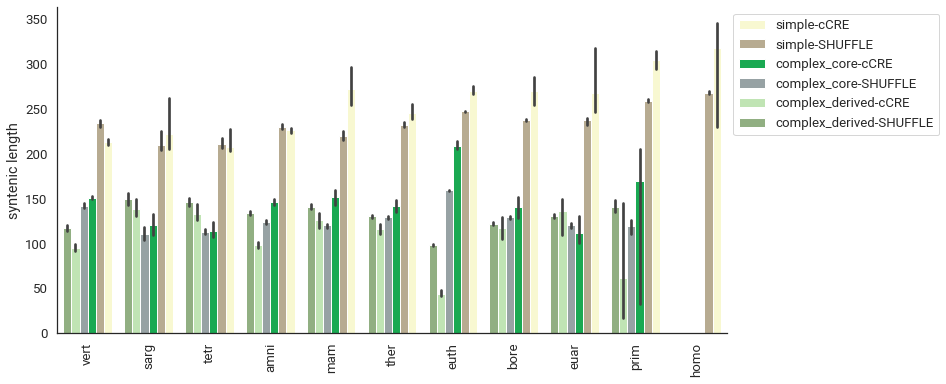

In [61]:
x = "mrca_2"
y = "syn_len"
hue = "id2"
palette = yg_shuf
outf = f"{RE}ALL_cCRE_syn_len_mrca_2.pdf"
plot_mrca_stratified(x, y, data, hue, palette, outf)

## mean lengths

In [64]:
comp = "all_cCRE_v_shuffle"

lens = sum_archlen.groupby(["id", "arch"])["syn_len"].mean().reset_index()
pcts = sum_archlen.groupby(["id", "arch"])["pct_enh"].mean().reset_index()

with open(stat_f, "a") as writer:
    writer.write("\n\n#syn_len#\n\n")
    for i, row in lens.iterrows():
        writer.write(row.to_string())
    writer.write("\n\n#percent_syn_len#\n\n")
    for i, row in pcts.iterrows():
        writer.write(row.to_string())

## quantify mwu on architecture, comparing cCRE v. SHUFFLE ids

In [69]:
dataset_col = "arch" # first level - simple, complex core, complex derived
id_col = "id" # do mwu separating on this variable
test_dif = "syn_len" # calculate mwu from these variables' values

mwu_df = get_mwu( dataset_col, id_col, test_dif, sum_archlen, stat_f)

#%% do mwu on architecture, comparing cCRE v. cCRE ids

dataset_col = "arch" # first level - simple, complex core, complex derived
id_col = "arch" # do mwu separating on this variable
test_dif = "syn_len" # calculate mwu from these variables' values

mwu_df = get_mwu( dataset_col, id_col, test_dif, sum_archlen, stat_f)

simple
SHUFFLE
cCRE
val list len 2
complex_derived
SHUFFLE
cCRE
val list len 2
complex_core
SHUFFLE
cCRE
val list len 2
comparison       arch_SHUFFLE_v_cCRE
dataset                       simple
stat                     4.37573e+09
P                        0.000679461
medianSHUFFLE                    250
mediancCRE                       247
meanSHUFFLE                   257.92
meancCRE                     256.433
comparison       arch_SHUFFLE_v_cCRE
dataset              complex_derived
stat                     2.52278e+09
P                       2.33446e-141
medianSHUFFLE                    116
mediancCRE                        95
meanSHUFFLE                  126.445
meancCRE                     112.056
comparison       arch_SHUFFLE_v_cCRE
dataset                 complex_core
stat                     2.61584e+09
P                        8.27018e-60
medianSHUFFLE                    142
mediancCRE                       154
meanSHUFFLE                  151.541
meancCRE                     

/home/fongsl/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/fongsl/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/fongsl/.local/lib/python3.6/site-packages/scipy/stats/stats.py:7028: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


simple
complex_derived
complex_core
val list len 3
complex_core
simple
complex_derived
complex_core
val list len 3
comparison               arch_simple_v_complex_derived
dataset                                         simple
stat                                                 0
P                                                    0
mediansimple                                       250
mediancomplex_derived                              NaN
meansimple                                     257.812
meancomplex_derived                                NaN
comparison               arch_simple_v_complex_derived
dataset                                complex_derived
stat                                                 0
P                                                    0
mediansimple                                       NaN
mediancomplex_derived                              113
meansimple                                         NaN
meancomplex_derived                            124.719
compa

In [70]:
#%% get arch counts

arch_count = enh[["core_remodeling", "enh_id"]].drop_duplicates().groupby("core_remodeling")["enh_id"].count().reset_index()
arch_count.columns = ["core_remodeling", "count_arch"]
arch_count["total"] = arch_count.count_arch.sum()
arch_count["percent"] = arch_count.count_arch.divide(arch_count.total)

with open(stat_f, "a") as writer:
    writer.write("\n\n#percent_syn_len#\n\n")
    for i, row in arch_count.iterrows():
        writer.write(row.to_string())

# GET MRCA FREQUENCIES

In [71]:
cols = ["id", "arch", "mrca_2"]
var = "mrca_2"
age_arch_freq, age_arch_fc = MRCA_frequency(df, cols, var, stat_f)


cols = ["id", "mrca_2"]
var = "mrca_2"
age_freq, age_fc = MRCA_frequency(df, cols, var, stat_f)


#%%

id                      cCRE
arch            complex_core
mrca_2                 0.144
counts                     7
total_id               38018
freq             0.000184123
dataset_name            cCRE
Name: 0, dtype: object
id                      cCRE
arch            complex_core
mrca_2                 0.146
counts                   144
total_id               38018
freq              0.00378768
dataset_name            cCRE
Name: 1, dtype: object
id                      cCRE
arch            complex_core
mrca_2                 0.167
counts                   804
total_id               38018
freq               0.0211479
dataset_name            cCRE
Name: 2, dtype: object
id                      cCRE
arch            complex_core
mrca_2                  0.19
counts                  7050
total_id               38018
freq                0.185438
dataset_name            cCRE
Name: 3, dtype: object
id                      cCRE
arch            complex_core
mrca_2                 0.425
counts   

id                     cCRE
mrca_2                    0
counts                   42
total_id             114690
freq            0.000366205
dataset_name           cCRE
Name: 0, dtype: object
id                   cCRE
mrca_2              0.144
counts               5122
total_id           114690
freq            0.0446595
dataset_name         cCRE
Name: 1, dtype: object
id                   cCRE
mrca_2              0.146
counts               2718
total_id           114690
freq            0.0236987
dataset_name         cCRE
Name: 2, dtype: object
id                   cCRE
mrca_2              0.167
counts               8945
total_id           114690
freq            0.0779929
dataset_name         cCRE
Name: 3, dtype: object
id                  cCRE
mrca_2              0.19
counts             31400
total_id          114690
freq            0.273781
dataset_name        cCRE
Name: 4, dtype: object
id                  cCRE
mrca_2             0.425
counts             12296
total_id          114690

In [72]:
age_arch_fc.head()

,id_x,arch,mrca_2,counts_x,total_id_x,freq_x,dataset_name_x,id_y,counts_y,total_id_y,freq_y,dataset_name_y,fold_change
0,SHUFFLE,complex_core,0.144,1696,279918,0.006059,SHUFFLE,cCRE,7,38018,0.000184,cCRE,0.030389
1,SHUFFLE,complex_core,0.146,7660,279918,0.027365,SHUFFLE,cCRE,144,38018,0.003788,cCRE,0.138412
2,SHUFFLE,complex_core,0.167,33540,279918,0.119821,SHUFFLE,cCRE,804,38018,0.021148,cCRE,0.176496
3,SHUFFLE,complex_core,0.190,139151,279918,0.497113,SHUFFLE,cCRE,7050,38018,0.185438,cCRE,0.373031
4,SHUFFLE,complex_core,0.425,29248,279918,0.104488,SHUFFLE,cCRE,3729,38018,0.098085,cCRE,0.938724


In [73]:
mrcas = age_arch_fc["mrca_2"].drop_duplicates()
pd.merge(mrcas, age_arch_fc.loc[age_arch_fc.arch == "complex_derived"][["mrca_2", "counts_y"]], how = "left")


,mrca_2,counts_y
0,0.144,3419.0
1,0.146,2463.0
2,0.167,7543.0
3,0.190,13230.0
4,0.425,6740.0
5,0.497,3417.0
6,0.606,9524.0
7,0.656,2116.0
8,0.756,1568.0
9,0.867,NaN


# Fold change, all archs in one graph

ValueError: #f7fcb9 is not a valid palette name

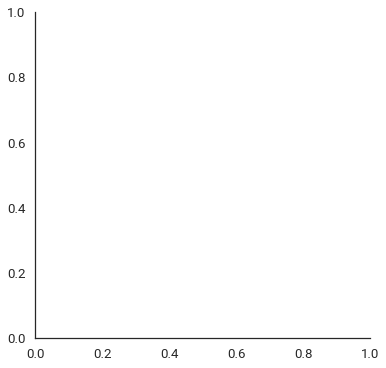

In [84]:
#plot_arch_freq(age_arch_freq, age_freq)
#plot_arch_fc(age_arch_fc, age_fc, GENOME_BUILD, "all")

# Figure 2B
## Fold change

### derived v. shuffle

hg38 complex_derived
dict_keys(['age_arch'])


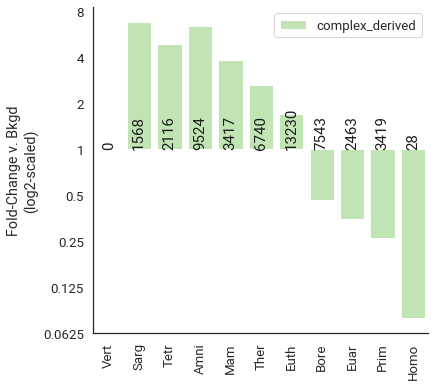

In [86]:
plot_arch_fc(age_arch_fc, age_fc, GENOME_BUILD, "complex_derived")

### complex core v. shuffle

hg38 complex_core
dict_keys(['age_arch'])


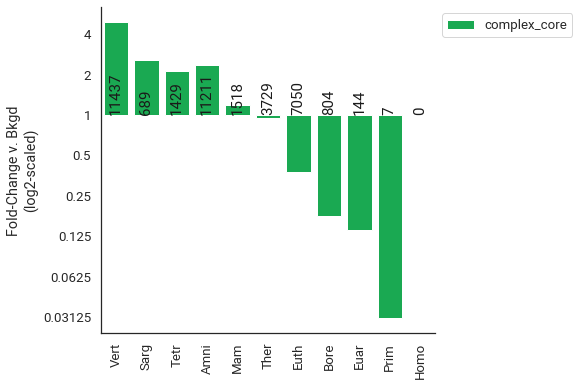

In [87]:
plot_arch_fc(age_arch_fc, age_fc,GENOME_BUILD, "complex_core")

### simple v. simple shuffle

hg38 simple
dict_keys(['age_arch'])


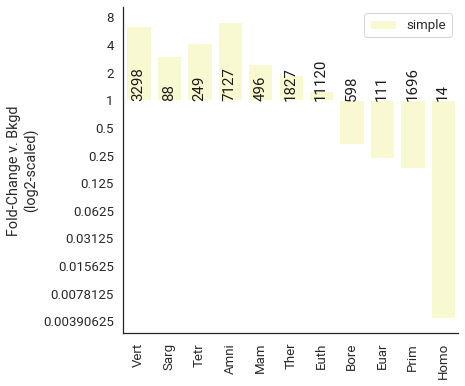

In [88]:
plot_arch_fc(age_arch_fc, age_fc, GENOME_BUILD, "simple")

In [72]:
2**(-3)

0.125

In [ ]:
der = df.loc[df.core == 0]
der_enh = der.loc[der.id == "cCRE", "mrca_2"]
der_shuf = der.loc[der.id == "SHUFFLE", "mrca_2"]
stats.mannwhitneyu(der_enh, der_shuf)
der.groupby("id")["mrca_2"].median()

In [ ]:
"""
id
cCRE     0.175
SHUFFLE    0.152
Name: mrca_2, dtype: float64
"""
der.groupby("id")["mrca_2"].mean()
"""
id
cCRE     0.206010
SHUFFLE    0.172115
Name: mrca_2, dtype: float64
"""